In [1]:
!pip install scikeras

In [2]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 91.0 MB/s eta 0:00:00


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [5]:
# Load the dataset and rescale
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Add channel dimension to work with grid search
train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

# Normalize pixel values
train_images = train_images / 255.0
test_images = test_images / 255.0

print("Train images shape:", train_images.shape)
print("Test images shape:", test_images.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train images shape: (60000, 28, 28, 1)
Test images shape: (10000, 28, 28, 1)


In [6]:
# Create CNN model function with customizable hyperparameters
def create_model(optimizer='adam', learning_rate=0.001):

  # Set up learning rates for different optimizers which will be tuned in grid search
  if optimizer == 'adam':
    opt = Adam(learning_rate=learning_rate)
  elif optimizer == 'sgd':
    opt = SGD(learning_rate=learning_rate)
  else:
    raise ValueError('Not a valid optimizer for this function')

  # Define the model
  model = models.Sequential()

  # Block 1
  model.add(tf.keras.Input(shape=(28,28,1)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2,2), strides=2))
  model.add(layers.Dropout(0.5))

  # Block 2
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.BatchNormalization())

  # Block 3
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.BatchNormalization())

  # Flatten and dense layers
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(10, activation='softmax'))

  model.compile(optimizer=opt,
                loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy']
  )

  return model


In [7]:
# Wrap the model in a keras wrapper so it can be used in sklearn functions
model = KerasClassifier(model=create_model, verbose=0)

# Define a grid of hyperparams to test
param_grid = {
    'model__optimizer': ['adam', 'sgd'],
    'model__learning_rate': [0.001, 0.01],
    'batch_size': [64, 128]
}

# Perform grid search and save the best found values
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2, scoring='accuracy')
result = grid_search.fit(train_images, train_labels, epochs=10)

best_params = result.best_params_
print('Best Parameters: ', best_params)
print('Best Score: ', result.best_score_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END batch_size=64, model__learning_rate=0.001, model__optimizer=adam; total time=  43.4s
[CV] END batch_size=64, model__learning_rate=0.001, model__optimizer=adam; total time=  31.9s
[CV] END batch_size=64, model__learning_rate=0.001, model__optimizer=adam; total time=  33.4s
[CV] END batch_size=64, model__learning_rate=0.001, model__optimizer=sgd; total time=  30.7s
[CV] END batch_size=64, model__learning_rate=0.001, model__optimizer=sgd; total time=  28.8s
[CV] END batch_size=64, model__learning_rate=0.001, model__optimizer=sgd; total time=  30.5s
[CV] END batch_size=64, model__learning_rate=0.01, model__optimizer=adam; total time=  30.5s
[CV] END batch_size=64, model__learning_rate=0.01, model__optimizer=adam; total time=  31.5s
[CV] END batch_size=64, model__learning_rate=0.01, model__optimizer=adam; total time=  33.5s
[CV] END batch_size=64, model__learning_rate=0.01, model__optimizer=sgd; total time=  28.1s
[CV] END

In [8]:
# Create, train and evaluate the model
model = create_model(best_params['model__optimizer'], best_params['model__learning_rate'])

model.summary()

history = model.fit(train_images,
                    train_labels,
                    epochs = 10,
                    batch_size = best_params['batch_size'],
                    validation_split = 0.1
                    )

test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)
print('Test accuracy: ', test_accuracy)
print('Test Loss: ', test_loss)

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_75 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_75          │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_76          │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 9, 9, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_77          │ (None, 9, 9, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 5184)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 128)            │       663,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 721,354 (2.75 MB)

 Trainable params: 721,034 (2.75 MB)

 Non-trainable params: 320 (1.25 KB)

Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.7189 - loss: 0.8346 - val_accuracy: 0.8335 - val_loss: 0.4767
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8485 - loss: 0.4143 - val_accuracy: 0.8938 - val_loss: 0.2888
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8743 - loss: 0.3487 - val_accuracy: 0.9008 - val_loss: 0.2596
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8900 - loss: 0.3124 - val_accuracy: 0.9042 - val_loss: 0.2593
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8958 - loss: 0.2883 - val_accuracy: 0.9100 - val_loss: 0.2406
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8998 - loss: 0.2705 - val_accuracy: 0.9102 - val_loss: 0.2328
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9089 - loss: 0.2493 - val_accuracy: 0.9123 - val_loss: 0.2352
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9111 - loss: 0.2436 - val_accuracy:

In [9]:
# Make predictions and show metrics
y_pred = model.predict(test_images)

# Convert probabilities to classes
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(test_labels, y_pred_classes))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.83      0.93      0.87      1000
           1       1.00      0.98      0.99      1000
           2       0.79      0.93      0.86      1000
           3       0.90      0.94      0.92      1000
           4       0.90      0.79      0.84      1000
           5       0.99      0.96      0.98      1000
           6       0.83      0.67      0.74      1000
           7       0.95      0.97      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.96      0.97      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



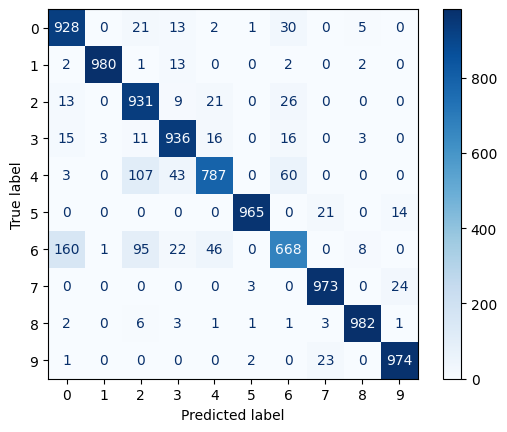

In [11]:
# Plot a confusion matrix
cm = confusion_matrix(test_labels, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10)) # 10 classes in Fashion MNIST, [0-9]
disp.plot(cmap=plt.cm.Blues)
plt.show()